# Final Project

## Course: Introduction to GPU Programming - EN.605.617.81.SP23
## Student: Vincent Kowalski
## Date: April 27, 2023

## Machine Vision for Fire Recognition

The purpose of this application is to create a Machine Learning Model that can recognize wildfires.  This model will be a key component in the construction of wildfire identifying/fighting drones. This application uses TensorFlow Convolutional Neural Networks (CNNs) and uses the GPUs made avaiable through Google Colab. It forms the basis for:
 - Comparisons with other GPU-based Machine Vision Technology
 - Mobile Deployment of Machine Vision Models


### Perform the required library imports

In [1]:

# perform imports of libraries used in the app
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from keras.preprocessing import image
from keras.utils import load_img, img_to_array

# set the backgound for seaborn plots
sns.set_style('darkgrid')

### Run the NVIDIA System Management Interface (nvidia-smi) which is a command line utility that provides management and monitoring capabilities for NVIDIA GPUs and their drivers.

In [2]:
# run nvidia-smi as a bash command
!nvidia-smi 


Fri Apr 28 21:11:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mount the drive in Google Drive where the datasets exist

In [3]:
# perform the mount of the content 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read in the data:
 - Fire Images
 - Non-Fire Images <br>
from their respective directories in Google Drive

#### Dataframe Structure
Pandas dataframes are used in this app to store the locations of image files and their associated labels, i.e., whether then are an image of a fire or a non-fire scene.<br>
Their are two columns in the dataframe:
 1. The path to the image file (the feature)
 2. The label (fire or non-fire) that is the target of the Machine Vision model

In [4]:
# suppress the annoying warning messages that tell you that some day the append function will be deprecated
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# create an empty DataFrame
df = pd.DataFrame(columns=['path','label'])

# loop over fire images and label them 'fire' (= 0)
for dirname, _, filenames in os.walk('/content/drive/My Drive/fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

# loop over non fire images and label them 'non_fire' (= 1)
for dirname, _, filenames in os.walk('/content/drive/My Drive/fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        # print(os.path.join(dirname, filename))

# shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
# display the first 25 elements of the dataframe
df.head(25)

path     label
0   /content/drive/My Drive/fire_dataset/fire_imag...      fire
1   /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
2   /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
3   /content/drive/My Drive/fire_dataset/fire_imag...      fire
4   /content/drive/My Drive/fire_dataset/fire_imag...      fire
5   /content/drive/My Drive/fire_dataset/fire_imag...      fire
6   /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
7   /content/drive/My Drive/fire_dataset/fire_imag...      fire
8   /content/drive/My Drive/fire_dataset/fire_imag...      fire
9   /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
10  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
11  /content/drive/My Drive/fire_dataset/fire_imag...      fire
12  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
13  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
14  /content/drive/My Drive/fire_dataset/fire_imag...      fire
15  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
16  /content/drive/My Drive/fire_dataset/fire_imag...      fire
17  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
18  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
19  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
20  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
21  /content/drive/My Drive/fire_dataset/fire_imag...      fire
22  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
23  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire
24  /content/drive/My Drive/fire_dataset/fire_imag...      fire

## Display a countplot of the data

In [5]:
# display a bar chart and pie chart of the fire vs non-fire data
# the datasets have roughly the same number of elements (i.e., images)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['green','orange'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['green','orange'])),
    row=1, col=2)


**Roughly the same number of fire and non-fire images**

## Display a sampling (10 of each) of fire and non-fire images  
## to give an idea what the images look like

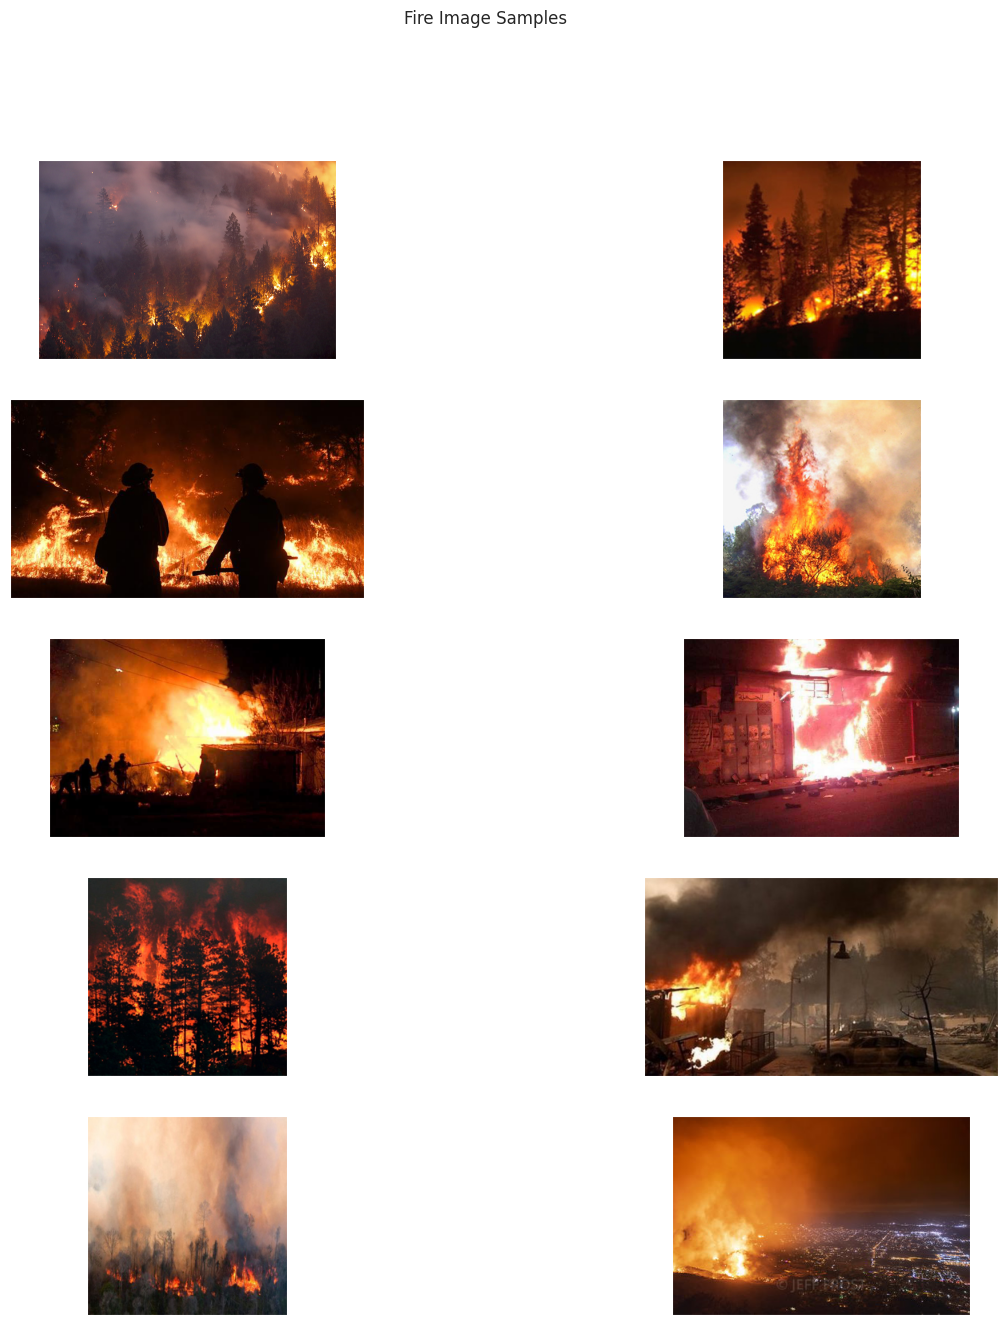

In [6]:
# label 'fire' for images with fire
label = 'fire' 
data = df[df['label'] == label]
sns.set_style('dark')

# show a sampling of 10 fire images
pics = 10 
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Fire Image Samples')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = load_img(path)
    img = img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

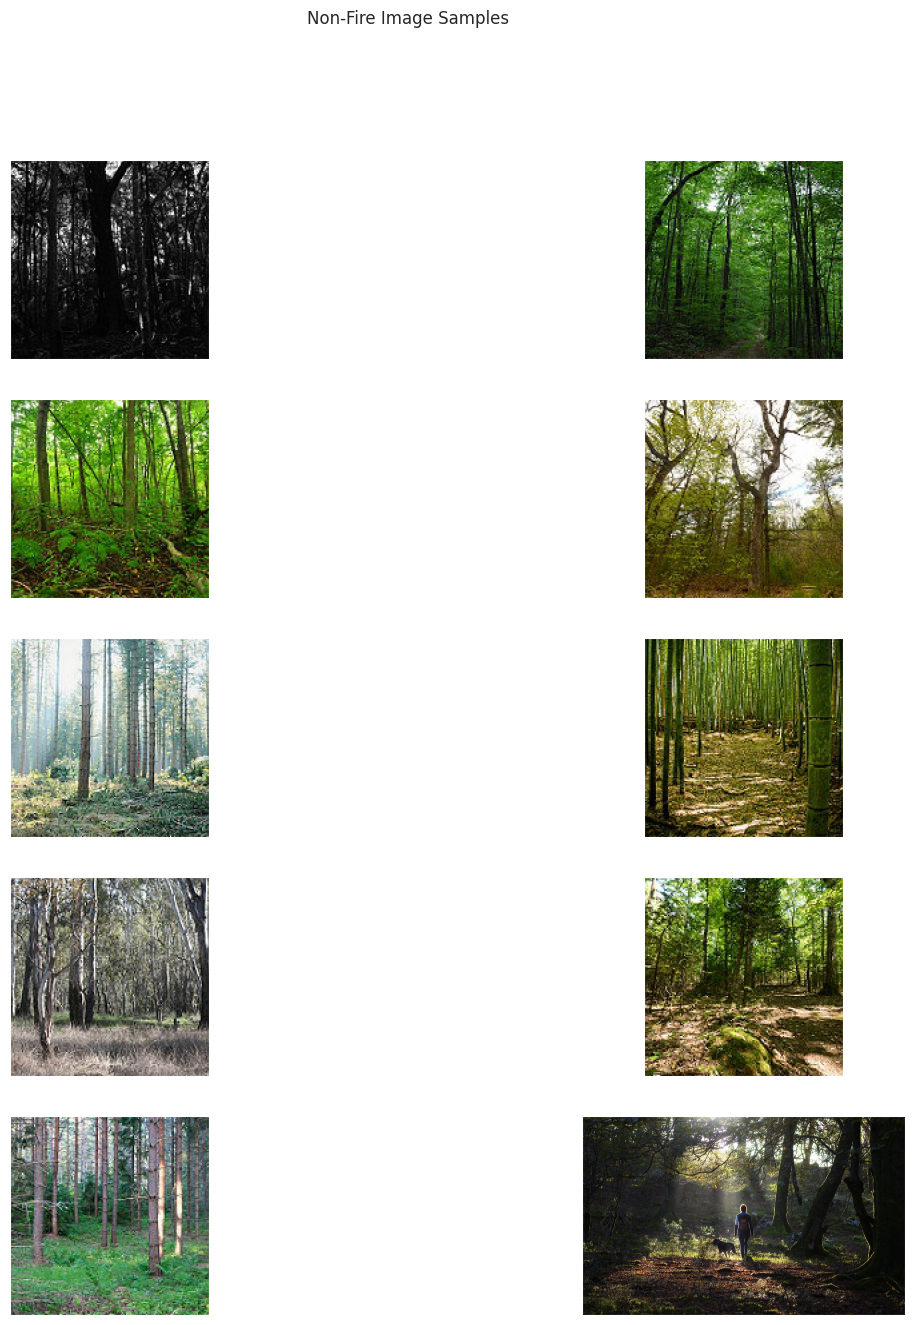

In [7]:
# label 'non_fire' for images without fire
label = 'non_fire' 
data = df[df['label'] == label]
sns.set_style('dark')

# display a sampling of 10 non-fire images
pics = 10 
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Non-Fire Image Samples')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = load_img(path)
    img = img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

## Display the distribution of the fire and non-fire images

In [8]:
# define the shaper function
def shaper(row):
    # the following print statements are useful in debugging
    # the input training sets
    # but are commented out as they produce a lot of output
    #print(" row path = ")
    #print(row['path'])
    shape = load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

path     label  height  width
0  /content/drive/My Drive/fire_dataset/fire_imag...      fire     450    878
1  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire     150    150
2  /content/drive/My Drive/fire_dataset/non_fire_...  non_fire     150    150
3  /content/drive/My Drive/fire_dataset/fire_imag...      fire     600    901
4  /content/drive/My Drive/fire_dataset/fire_imag...      fire     619   1100

## Plot the Distribution

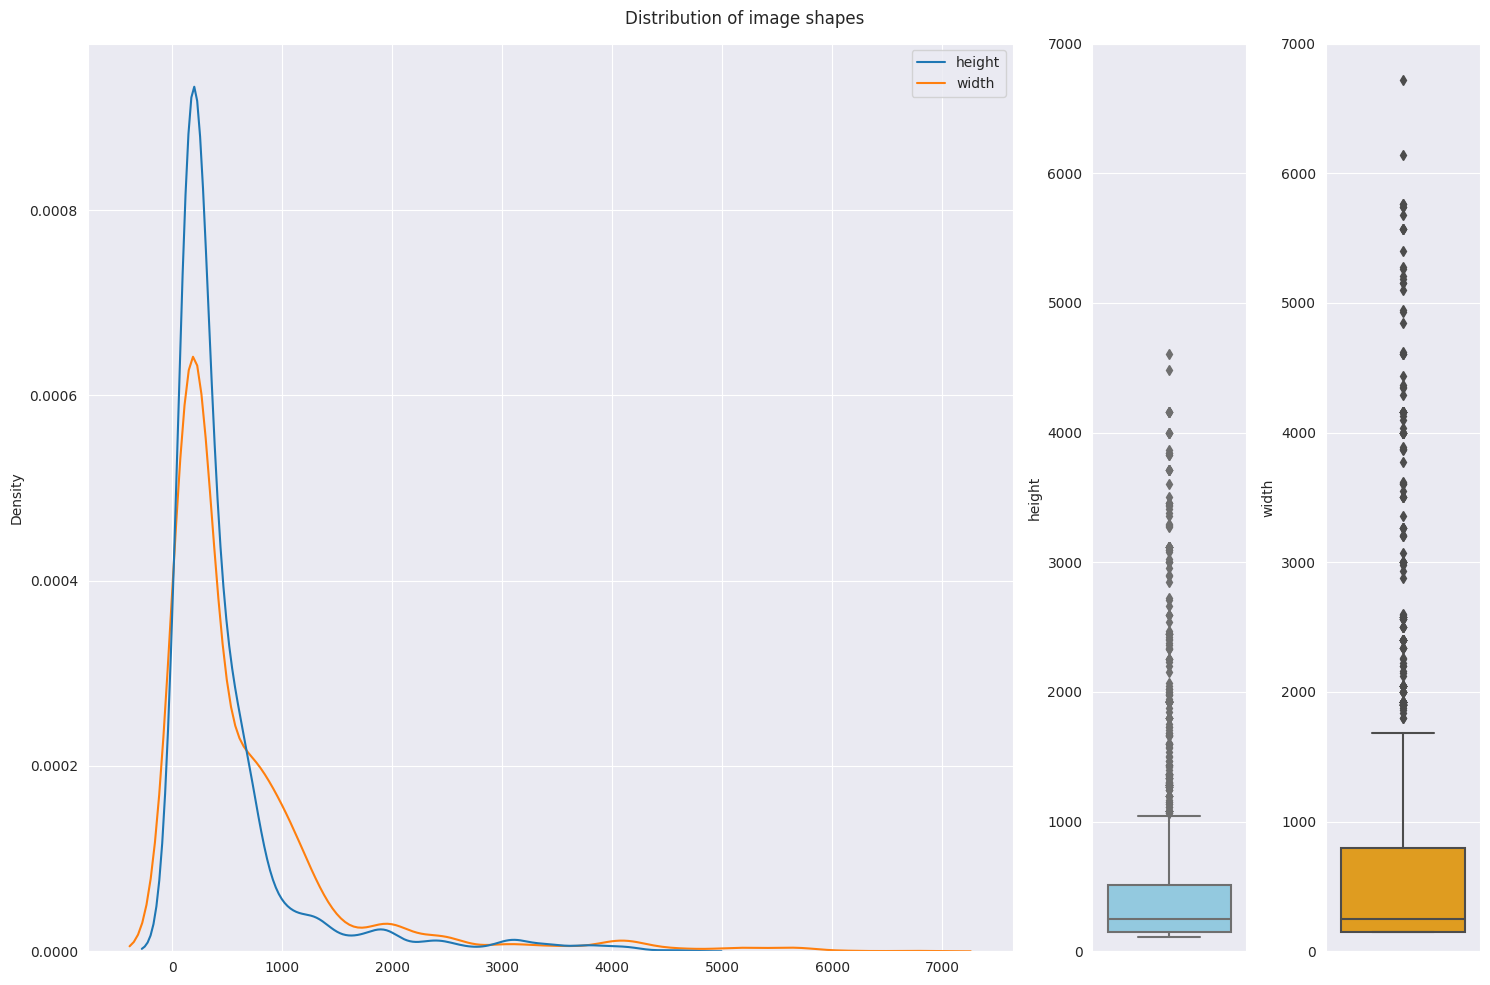

In [9]:
# plot the distribution

sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

## Instantiate an ImageDataGenerator object
### to be used in creating the images for the training and validation sets

In [10]:
# import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# instantiate the ImageDataGenerator
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

## Create training and validation sets

In [12]:
# generate the training and validation sets
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 2011 validated image filenames belonging to 2 classes.
Found 502 validated image filenames belonging to 2 classes.


#### Class indices assigned by the Image generator

In [13]:
# determine the class indexes
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


## Visualizing the generated images in training set

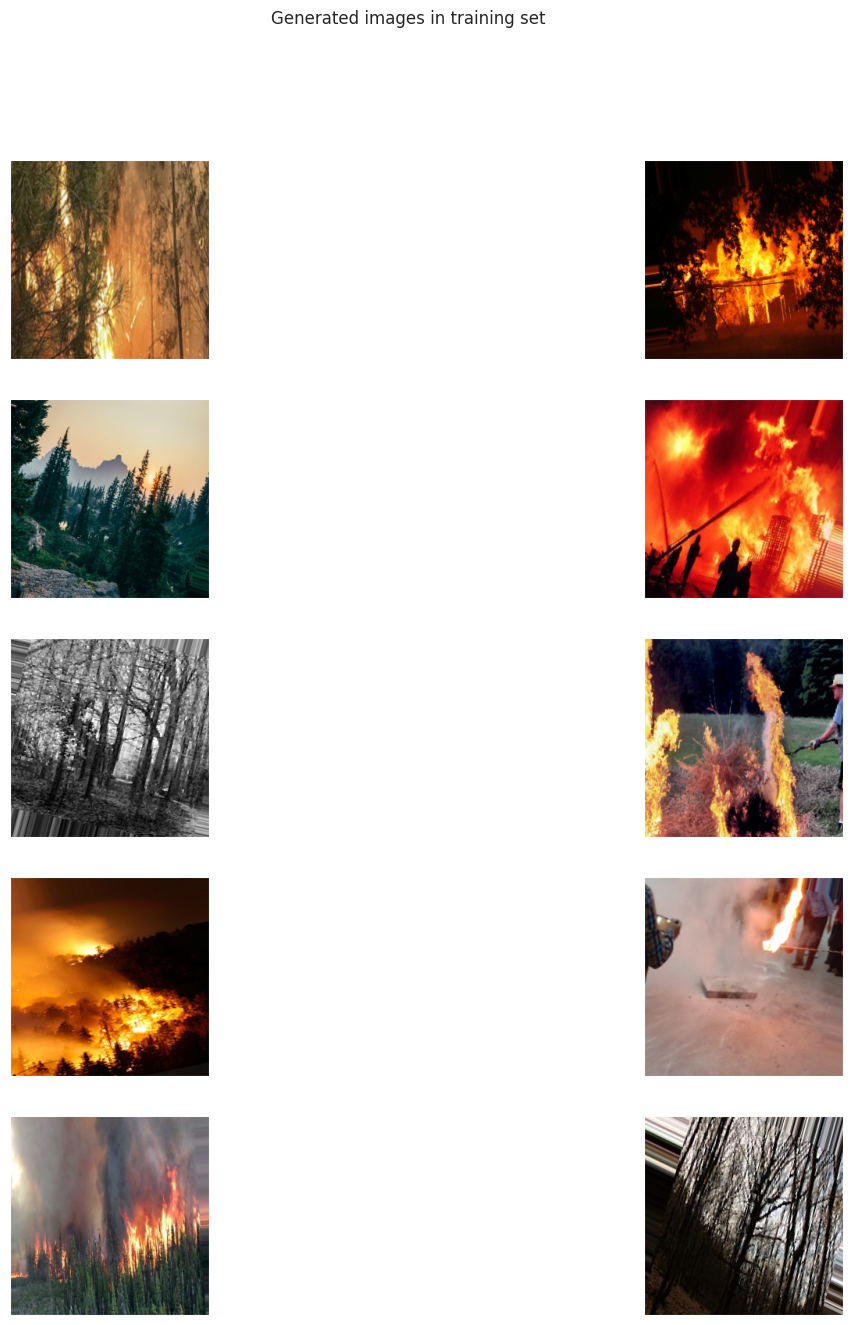

In [14]:
sns.set_style('dark')
# display a sampling of 10 images (both fire and non-fire)
pics = 10 
# plot the images
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

## Define the Convolutional Neural Network (CNN) Model

In [15]:
# perform imports from tensorflow
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [16]:

# Define the CNN using 2 CNN layers and 3 Dense layers, the final one for output
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

### Display a Summary of the Model



In [17]:
# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

## Compile the Model

In [18]:
# perform imports
from keras.metrics import Recall,AUC
from keras.utils import plot_model

In [19]:
# compile model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

## Define callbacks in case the model is accurate enough before the full 15 epochs


In [20]:
# import callback libraries
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [21]:
# define callbacks
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)



## Train the Machine Vision Model

In [22]:
# train the model
model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/15
63/63 [==============================] - 100s 1s/step - loss: 0.2312 - accuracy: 0.9010 - recall: 0.9092 - auc: 0.9680 - val_loss: 0.0881 - val_accuracy: 0.9701 - val_recall: 0.9800 - val_auc: 0.9947 - lr: 0.0010
Epoch 2/15
63/63 [==============================] - 88s 1s/step - loss: 0.1242 - accuracy: 0.9543 - recall: 0.9561 - auc: 0.9896 - val_loss: 0.1297 - val_accuracy: 0.9562 - val_recall: 0.9920 - val_auc: 0.9946 - lr: 0.0010
Epoch 3/15
63/63 [==============================] - 87s 1s/step - loss: 0.1335 - accuracy: 0.9543 - recall: 0.9570 - auc: 0.9875 - val_loss: 0.0860 - val_accuracy: 0.9641 - val_recall: 0.9760 - val_auc: 0.9945 - lr: 0.0010
Epoch 4/15
63/63 [==============================] - 87s 1s/step - loss: 0.0963 - accuracy: 0.9637 - recall: 0.9658 - auc: 0.9939 - val_loss: 0.0877 - val_accuracy: 0.9681 - val_recall: 0.9720 - val_auc: 0.9951 - lr: 0.0010
Epoch 5/15
63/63 [==============================] - 87s 1s/step - loss: 0.1040 - accuracy: 0.9622 - recall:

## Display the Model Metrics at each Epoch



In [23]:
# determine the model history
history= model.history.history

# plot the history
px.line(history,title = "Metrics at each Epoch")

## Evaluate the Model<br>
Display each of the following metrics:<br>
 - loss
 - accuracy
 - recall
 - AUC (Area Under Curve)

In [24]:
# perform model evaluation
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

16/16 [==============================] - 21s 1s/step - loss: 0.0778 - accuracy: 0.9721 - recall: 0.9720 - auc: 0.9953
loss: 0.08
accuracy: 0.97
recall: 0.97
auc: 1.00


## Enhance the Model using Transfer Learning



In [25]:
# perform imports
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dropout

In [26]:
# add the transfer learning model 
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#turn off training
xception.trainable = False

x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

83683744/83683744 [==============================] - 1s 0us/step


## Compile the revised model

In [27]:
# compile the model

model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

## Train the revised model

In [28]:
# train the model

history2 = model2.fit(x = train_gen,batch_size=32,epochs=15,callbacks = [early_stoppping,reduce_lr_on_plateau],validation_data = val_gen)

Epoch 1/15
63/63 [==============================] - 106s 2s/step - loss: 0.5306 - accuracy: 0.9373 - recall_1: 0.9424 - auc_1: 0.9648 - val_loss: 0.1687 - val_accuracy: 0.9781 - val_recall_1: 0.9600 - val_auc_1: 0.9937 - lr: 0.0010
Epoch 2/15
63/63 [==============================] - 98s 2s/step - loss: 0.2325 - accuracy: 0.9667 - recall_1: 0.9648 - auc_1: 0.9836 - val_loss: 0.1300 - val_accuracy: 0.9861 - val_recall_1: 0.9720 - val_auc_1: 0.9940 - lr: 0.0010
Epoch 3/15
63/63 [==============================] - 89s 1s/step - loss: 0.1545 - accuracy: 0.9781 - recall_1: 0.9766 - auc_1: 0.9885 - val_loss: 0.1923 - val_accuracy: 0.9681 - val_recall_1: 0.9920 - val_auc_1: 0.9852 - lr: 0.0010
Epoch 4/15
63/63 [==============================] - 88s 1s/step - loss: 0.1563 - accuracy: 0.9816 - recall_1: 0.9795 - auc_1: 0.9904 - val_loss: 0.1731 - val_accuracy: 0.9681 - val_recall_1: 0.9400 - val_auc_1: 0.9894 - lr: 0.0010
Epoch 5/15
63/63 [==============================] - 90s 1s/step - loss: 0.1

### Display the Model Metrics at each Epoch

In [29]:
# plot the metrics at each epoch
px.line(history,title='Metrics at each Epoch')

## Evaluate the Model<br>
Display each of the following metrics:<br>
 - loss
 - accuracy
 - recall
 - AUC (Area Under Curve)

In [30]:
# perform model evaluation
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

16/16 [==============================] - 18s 1s/step - loss: 0.0805 - accuracy: 0.9721 - recall: 0.9720 - auc: 0.9967
loss: 0.08
accuracy: 0.97
recall: 0.97
auc: 1.00


## Fire Image Prediction


In [31]:
#Downloading the image (from the Insurance Journal)

!curl https://www.insurancejournal.com/app/uploads/2014/06/wildfire-580x387.jpg --output predict_fire.jpg


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 78297  100 78297    0     0   285k      0 --:--:-- --:--:-- --:--:--  285k


## Display the Fire Image

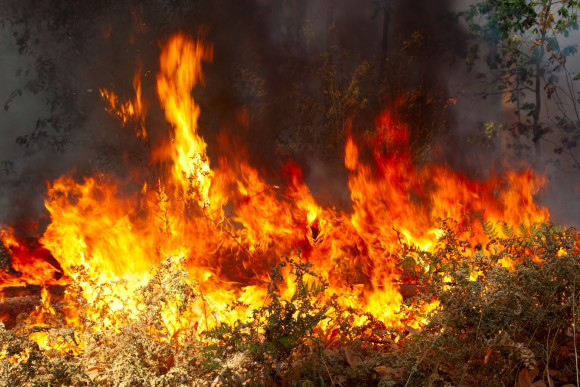

In [32]:
#loading the image
img_fire = load_img('predict_fire.jpg')
img_fire

### Scale / Normalize the image prior to prediction

In [33]:
# scale or normalize the image before performing prediction
img_fire = img_to_array(img_fire)/255
img_fire = tf.image.resize(img_fire,(256,256))
img_fire = tf.expand_dims(img_fire,axis=0)

# print the image dimensions
print("Image Shape",img_fire.shape)

Image Shape (1, 256, 256, 3)


### Perform the prediction using the Machine Vision Model
### indeed this is a **fire** scene

In [34]:
# perform the prediction
prediction = int(tf.round(model2.predict(x=img_fire)).numpy()[0][0])

# print the prediction results
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 [==============================] - 1s 1s/step
The predicted value is:  0 and the predicted label is: fire


## Non-Fire Image Prediction

In [35]:
#Downloading the image (from National Geographic)

!curl https://images.nationalgeographic.org/image/upload/t_edhub_resource_key_image/v1638892272/EducationHub/photos/hoh-river-valley.jpg --output predict_non_fire.jpg


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  134k  100  134k    0     0   998k      0 --:--:-- --:--:-- --:--:--  998k


## Display the Non-Fire Image

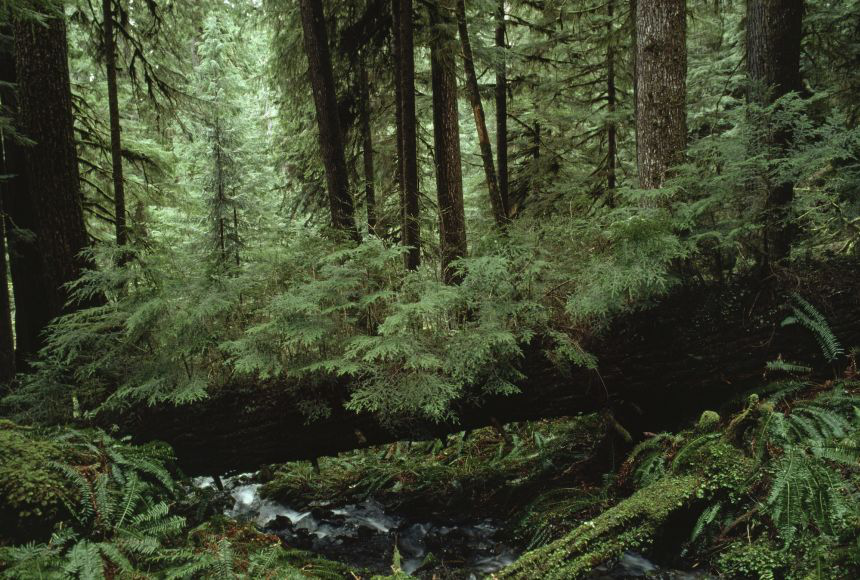

In [36]:
#loading the image
img_non_fire = load_img('predict_non_fire.jpg')
img_non_fire

### Scale / Normalize the image prior to prediction

In [37]:
# scale or normalize the image before performing prediction
img_non_fire = img_to_array(img_non_fire)/255
img_non_fire = tf.image.resize(img_non_fire,(256,256))
img_non_fire = tf.expand_dims(img_non_fire,axis=0)

# display the dimensionality of the image array
print("Image Shape",img_non_fire.shape)

Image Shape (1, 256, 256, 3)


### Perform the prediction using the Machine Vision Model
### indeed this is a **non-fire** scene

In [38]:
# peform the prediction
prediction = int(tf.round(model2.predict(x=img_non_fire)).numpy()[0][0])
# print the prediction result
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 [==============================] - 0s 35ms/step
The predicted value is:  1 and the predicted label is: non_fire
